Murilo Amaral  
Email: murilogmamaral@gmail.com  
Linkedin: https://www.linkedin.com/in/murilogmamaral/  

___
# Forecasting passenger flow at Brazilian airports
## 3 - Exploratory Data Analysis
Getting insights from passengers arrival data (SBSV, Salvador-BA).
___

### Libraries and Configuration

In [16]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as F
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
spark = SparkSession.builder.appName("DataAnalysis").getOrCreate()

### Loading dataset

In [17]:
airport = 'SBSV'
file_path = f'/Volumes/datalake/refined/anac/{airport}'
df = spark.read.parquet(file_path).toPandas()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228147 entries, 0 to 228146
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   company            228147 non-null  object 
 1   departure_country  228147 non-null  object 
 2   departure_city     228147 non-null  object 
 3   departure_airport  228147 non-null  object 
 4   arrival_date       228147 non-null  object 
 5   arrival_hour       228147 non-null  object 
 6   year               228147 non-null  int32  
 7   month              228147 non-null  int32  
 8   day                228147 non-null  int32  
 9   weekday            228147 non-null  int32  
 10  pax                228147 non-null  int64  
 11  dollar             228147 non-null  float64
 12  unemployment_rate  226094 non-null  float64
dtypes: float64(2), int32(4), int64(1), object(6)
memory usage: 19.1+ MB


In [4]:
# Renaming columns
df.columns = ['company', 'country', 'city', 'airport',
              'date', 'hour', 'year', 'month', 'day', 'weekday',
              'pax', 'dollar', 'u_rate']

In [5]:
# Isolating hour
df['hour'] = df['hour'].apply(lambda x: int(str(x)[0:2]))

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228147 entries, 0 to 228146
Data columns (total 13 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   company  228147 non-null  object 
 1   country  228147 non-null  object 
 2   city     228147 non-null  object 
 3   airport  228147 non-null  object 
 4   date     228147 non-null  object 
 5   hour     228147 non-null  int64  
 6   year     228147 non-null  int32  
 7   month    228147 non-null  int32  
 8   day      228147 non-null  int32  
 9   weekday  228147 non-null  int32  
 10  pax      228147 non-null  int64  
 11  dollar   228147 non-null  float64
 12  u_rate   226094 non-null  float64
dtypes: float64(2), int32(4), int64(2), object(5)
memory usage: 19.1+ MB


In [7]:
# Aggregation by hour
df_agg_by_hour = (
    df
    .groupby(['date','hour','weekday'],as_index=False)
    .agg({'pax': 'sum'})
)

# Aggregation by day
df_agg_by_day = (
    df
    .groupby(['date','year','month','weekday'],as_index=False)
    .agg({'dollar': 'mean','u_rate':'mean','pax': 'sum'})
)

# Aggregation by month
df_agg_by_month = (
    df
    .groupby(['year','month'],as_index=False)
    .agg({'dollar': 'mean','u_rate':'mean','pax': 'sum'})
)

___
## Exploratory Data Analysis

In [8]:
month_list   = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SET','OCT','NOV','DEC']
weekday_list = ['MON','TUE','WED','THR','FRI','SAT','SUN']

In [9]:
# Top 10 departure country
(
    df
    .groupby(['country','year'],as_index=False)['pax'].sum()
    .groupby('country')['pax'].mean().round().apply(int)
    .sort_values(ascending=False)
    [0:10]
)

country
BRASIL                       3198667
PORTUGAL                       50101
ARGENTINA                      34102
ESPANHA                        26224
ESTADOS UNIDOS DA AMÉRICA      11975
ALEMANHA                        7156
PANAMÁ                          5775
CHILE                           5706
CABO VERDE                      3009
COLÔMBIA                        2176
Name: pax, dtype: int64

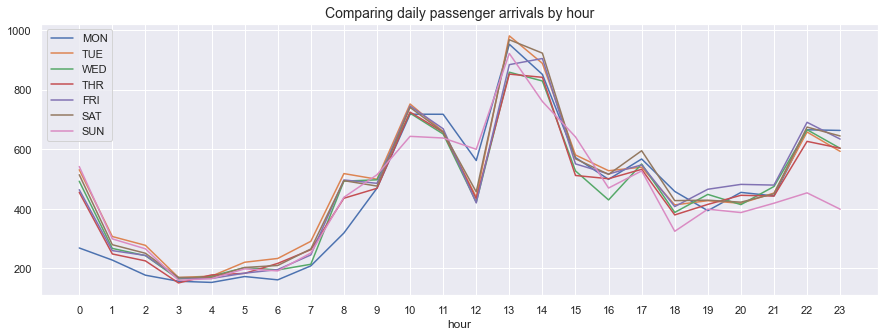

In [10]:
t = df_agg_by_hour.pivot_table(index='hour',columns='weekday',values='pax',aggfunc='mean')
t.plot(rot=0,figsize=(15,5))
plt.title('Comparing daily passenger arrivals by hour',fontsize=14)
plt.legend(weekday_list)
plt.xticks(range(0,24))
plt.show()

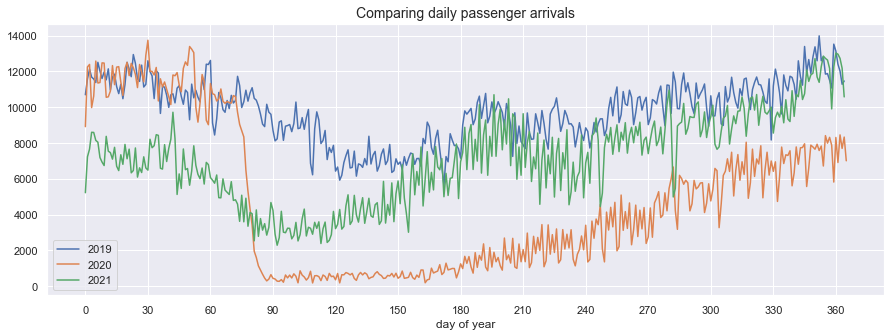

In [11]:
plt.title('Comparing daily passenger arrivals',fontsize=14)
years = range(2019,2022)
for year in years:
    df_agg_by_day['pax'][df_agg_by_day.year==year].reset_index(drop=True).plot(figsize=(15,5))
plt.legend(years)
plt.xticks(range(0,365,30))
plt.xlabel('day of year')
plt.show()

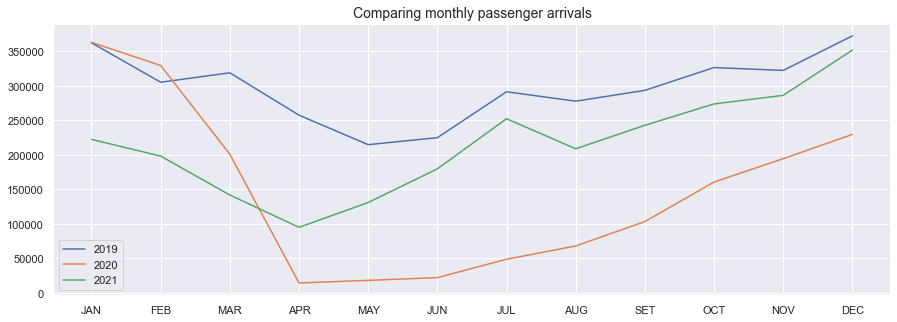

In [12]:
plt.title('Comparing monthly passenger arrivals',fontsize=14)
years = range(2019,2022)
for year in years:
    df_agg_by_month['pax'][df_agg_by_month.year==year].reset_index(drop=True).plot(figsize=(15,5))
plt.legend(years)
plt.xticks(range(0,12), month_list)
plt.show()

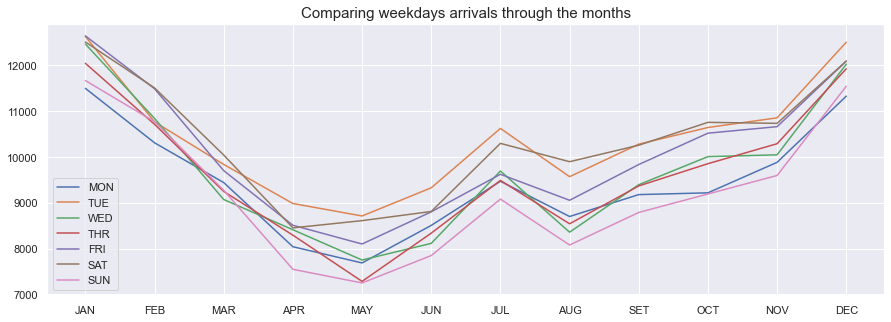

In [13]:
t = df_agg_by_day.pivot_table(index='month',columns='weekday',values='pax',aggfunc='mean')
t.columns = weekday_list
_, ax = plt.subplots(1,1,figsize=(15,5))
plt.title('Comparing weekdays arrivals through the months',fontsize=15)
ax.set_xticks(range(1,13))
ax.set_xticklabels(month_list)
t.plot(ax=ax)
plt.xlabel('')
plt.show()

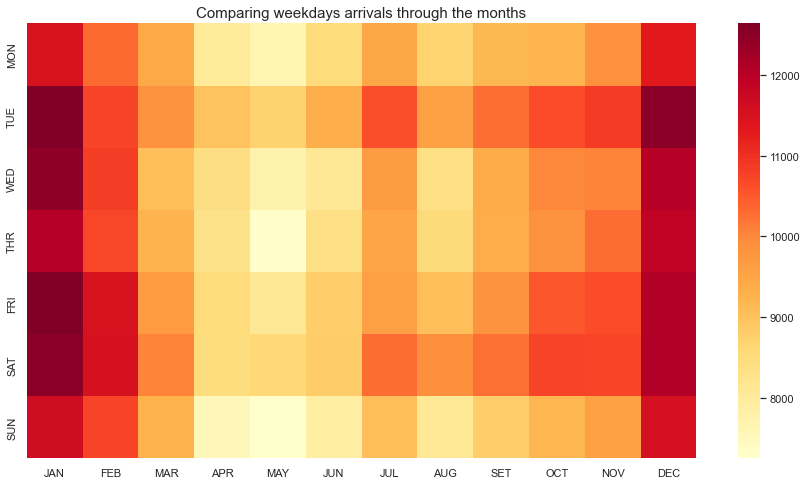

In [14]:
t = df_agg_by_day.pivot_table(index=['weekday'],columns=['month'],values='pax',aggfunc='mean')
t.index = weekday_list
t.columns = month_list
_, ax = plt.subplots(1,1,figsize=(15,8))
plt.title('Comparing weekdays arrivals through the months',fontsize=15)
sns.heatmap(t,cmap='YlOrRd',ax=ax)
plt.show()

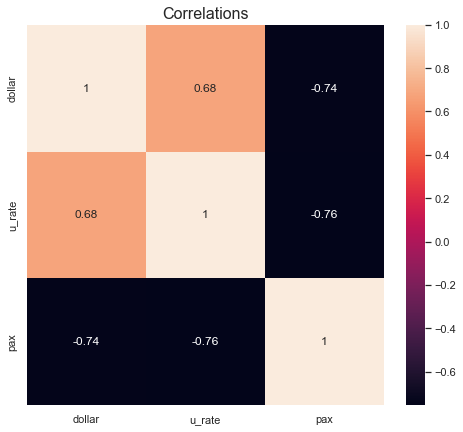

In [15]:
# Correlations
_, ax = plt.subplots(1,1,figsize=(8,7))
plt.title('Correlations',fontsize=16)
sns.heatmap(df_agg_by_month[['dollar','u_rate','pax']].corr(),annot=True)
plt.show()